## Raster to vector

For transformation of `Numpy` structures to vector data, we can use several tools. Simpliest is to use RasterIO interal tool.

### RasterIO-based vectorisation

Modul `rasterio.features` contains tools for raster to vector transformation. Output format of the `shapes()` function, is GeoJSON.

Another useful function is `sieve()`, which helps to remove too small areas.

One of the importat inputs for the output vectors is Affine transformation parameter. It will help to identify pixel position in the coordinate reference system on Earth.


In [3]:
import rasterio
import rasterio.features
from affine import Affine
import json

with rasterio.open("../../outputs/water.tif") as src:

    data = src.read(1)

Next step, we will clean the input data from small areas

In [22]:
cleaned = rasterio.features.sieve(data, 10)

As next step, we will convert data from raster to vector using transformation matrix of the source file

In [23]:
shapes = rasterio.features.shapes(cleaned, transform=src.transform)

Create empty GeoJSON structure

In [24]:
features = {
    "type": "FeatureCollection",
    "features": []
}

In [25]:
for (geom, val) in shapes:
    val = int(val)
    if val == 1:
        feature = {
            "type": "Feature",
            "properties": {
                "class": val,
            },
            "geometry": geom
        }

        features["features"].append(feature)

with open("../../outputs/water.geojson", "w") as out:
    json.dump(features, out)

Final vector data [water.geojson](../../outputs/water.geojson) can be opend in QGIS

![](images/water-vector.png)
OpenStreetMap as backound for our Water vector


## Vector to raster

For the other way around - burning vector values into raster file - we use `rasterize()` function

Let's write water vector as raster again:

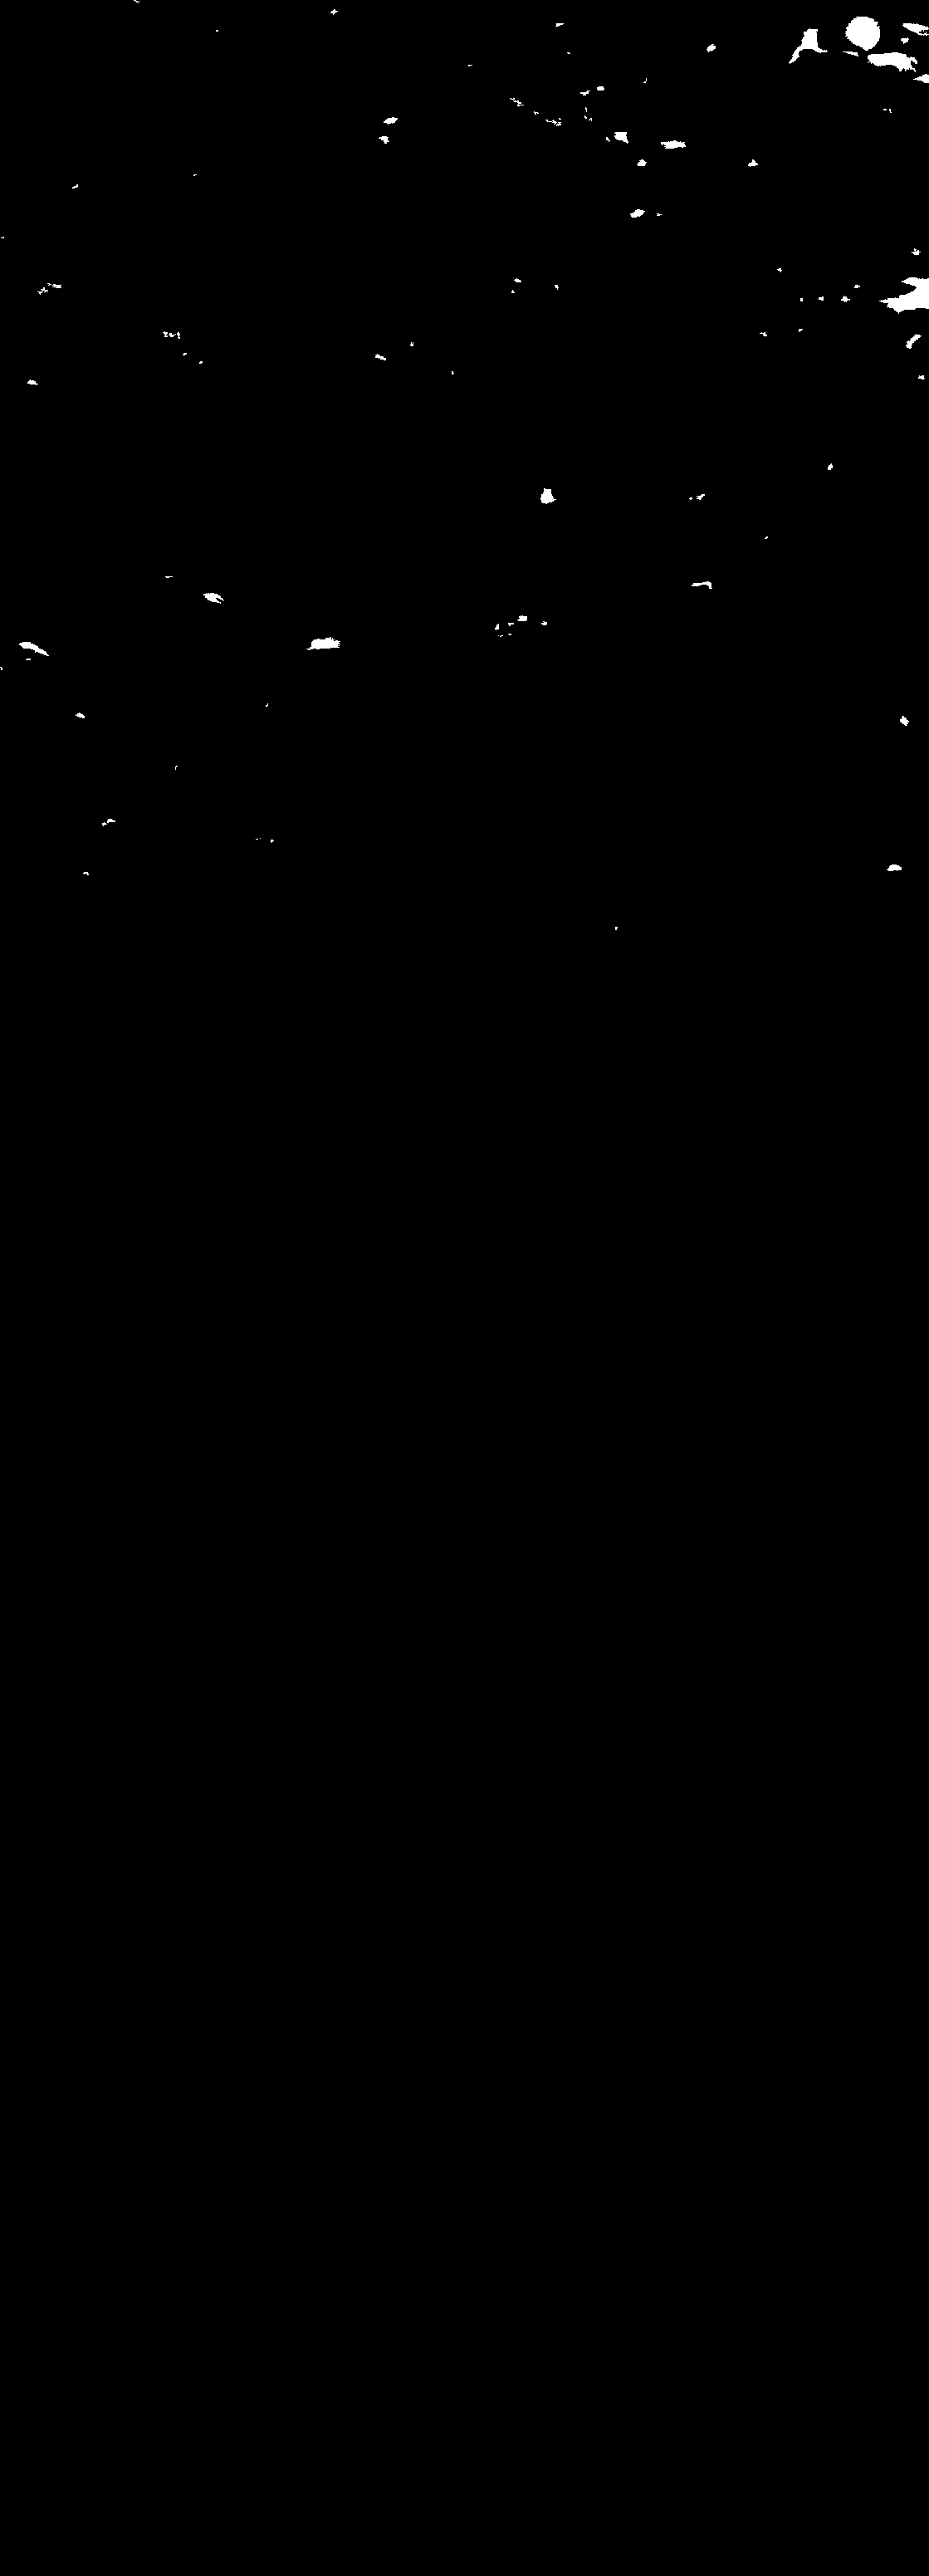

In [5]:
import rasterio
import rasterio.features
import fiona
from affine import Affine
import PIL.Image

resolution = 0.0001796

with fiona.open("../../outputs/water.geojson") as water:
    geotransform = (
        water.bounds[0], # left-bound
        resolution,      # X-resolution
        0.0,             # X-rotation
        water.bounds[3], # top-bound
        0.0,             # Y-rotation
        -1*resolution    # Y-resolution
    )
    transform = Affine.from_gdal(*geotransform)
    
    image = rasterio.features.rasterize(
            ((feature["geometry"], 255) for feature in water),
            out_shape=[int((water.bounds[2]-water.bounds[0])/resolution),
                       int((water.bounds[3]-water.bounds[1])/resolution)],
            transform=transform)

PIL.Image.fromarray(image.astype("uint8"), "L")

---
[<- Windowed reading and writing](04_windows.ipynb) | [Open Web Services (OWS) ->](../03_ows/00_intro.ipynb)